# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [1]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. I represent a position as a 2-tuple of the form `(row, col)`. 

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


Visualize the maze

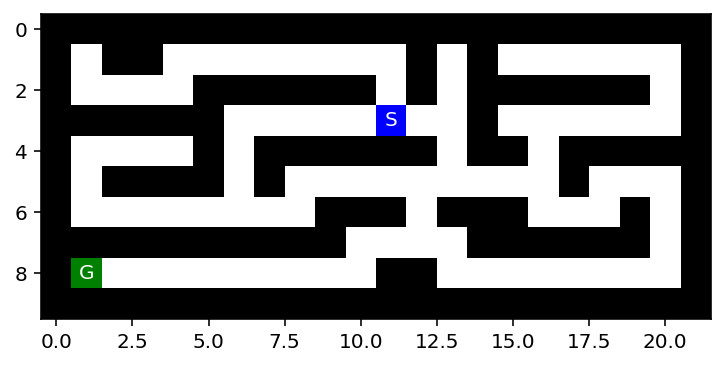

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [5]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

    # Following functions allow compatibility with built-in python data structures
    def __hash__(self):
        return self.pos.__hash__()

    def __eq__(self, obj):
        return self.pos.__eq__(obj.pos)

    def __lt__(self, obj):
        return self.cost.__lt__(obj.cost)

If needed, then you can add more fields to the class.


__Tree and memory management example:__ Create the root node and append the node for going east with a cost of 1.

In [6]:
import sys

print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))
# Note: -1 is used because passing root to getrefcount adds one reference
print("Root is now referenced twice. Reference count for garbage collection (root node):", sys.getrefcount(root)-1)

print()
print("Note that the root node is safe from garbage collection as long as we have also a reference in node2") 
root = None
print(root)
print("parent of node2 (reference to root node): ", repr(node2.parent))
print("Reference count for garbage collection (root node):", sys.getrefcount(node2.parent)-1)

print()
print("Path from root to node2")
path = node2.get_path_from_root()
print("References:", path)
print("Positions:", [n.pos for n in path])
print("Actions:", [n.action for n in path])
print("Cost:", [n.cost for n in path])


print()
print("Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage collection.")
node2 = None



Create root node
root: Node - pos = (0, 0); action = None; cost = 0
root (reference): <__main__.Node object at 0x000002303A1BCF10>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); action = E; cost = 1
parent of node2:  Node - pos = (0, 0); action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x000002303A1BCF10>
Root is now referenced twice. Reference count for garbage collection (root node): 2

Note that the root node is safe from garbage collection as long as we have also a reference in node2
None
parent of node2 (reference to root node):  <__main__.Node object at 0x000002303A1BCF10>
Reference count for garbage collection (root node): 1

Path from root to node2
References: [<__main__.Node object at 0x000002303A1BCF10>, <__main__.Node object at 0x0000023039D22430>]
Positions: [(0, 0), (0, 1)]
Actions: [None, 'E']
Cost: [0, 1]

Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is expo

# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth
* Maximum size of the frontier

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* Initial state - the agent's occupation of the starting location in a maze
* Actions - movement north, south, east, or west
* Transition model - defines how the agent's position within the maze changes depending on its current location and action.
* Goal state - the agent's occupation of the goal location in a maze
* Path cost - the number of actions the agent takes to reach the gotal state from the initial state

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information during search in the tree, and the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint, you need to implement DFS in a different way without a `reached` data structure and by releasing nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. You will see in your experiments that open spaces are a problem.

Wall time: 10.5 ms


<Figure size 432x288 with 0 Axes>

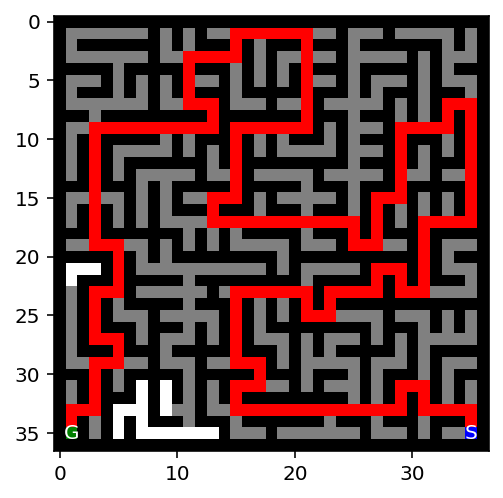

algorithm : BFS
path_cost : 210
nodes_expanded : 621
max_tree_depth : 211
max_tree_size : 624
max_frontier_size : 8


In [120]:
from collections import deque   # used as stack or queue for frontier
from operator import add, sub   # used for elementwise tuple addition in conjunction with map()

directions = {
    "N" : (0, 1),
    "E" : (1, 0),
    "S" : (0, -1),
    "W" : (-1, 0)
}

def breadth_first_search(maze):
    # Determine the inital and goal states
    initial = find_pos(maze)
    G = where(maze == 'G')
    goals = {(G[0][i], G[1][i]) for i in range(len(G[0]))}

    # Initialize data structures
    reached = set()
    frontier = deque()
    depth = 0
    metrics = {
        "path": [],
        "algorithm": "BFS",
        "path_cost": 0,
        "nodes_expanded": 0,
        "max_tree_depth": 0,
        "max_tree_size": 0,
        "max_frontier_size": 0
    }

    # Populate data structures
    current = Node(initial, None, None, 0)
    reached.add(current)
    frontier.append(current)

    # Loop while there are nodes in the frontier
    while len(frontier):
        # Pull node from frontier queue
        current = frontier.popleft()
        metrics["nodes_expanded"] += 1

        # Algorithm is complete if goal is expanded to
        if current.pos in goals:
            break

        # Check adjacent nodes in each direction
        for direction, modifier in directions.items():
            border = Node(tuple(map(add, current.pos, modifier)), current, direction, current.cost + 1)
            # Add adjacent node if it has not been visited and is not a wall
            if border not in reached and look(maze, border.pos) != 'X':
                reached.add(border)
                frontier.append(border)
                # Update metrics
                if border.cost > metrics["max_tree_depth"]:
                    metrics["max_tree_depth"] = border.cost
                metrics["max_tree_size"] += 1
        
        # Update max frontier size
        if len(frontier) > metrics["max_frontier_size"]:
            metrics["max_frontier_size"] = len(frontier)
    
    # Generate path
    metrics["path"] = current.get_path_from_root()
    metrics["path_cost"] = len(metrics["path"]) - 1

    # Update maze with reached and path nodes
    for r in reached:
        maze[r.pos[0], r.pos[1]] = '.'
    for p in metrics["path"]:
        maze[p.pos[0], p.pos[1]] = 'P'
    maze[initial[0], initial[1]] = 'S'
    for g in goals:
        maze[g[0], g[1]] = 'G'

    # Return metrics
    return metrics

# Test algorithm
%run maze_helper.py
with open("large_maze.txt", "r") as file:
    maze_str = file.read()
maze = parse_maze(maze_str)
%time metrics = breadth_first_search(maze)
show_maze(maze)
for key, value in metrics.items():
    if key != "path":
        print(key, ":", value)

Wall time: 9.18 ms


<Figure size 432x288 with 0 Axes>

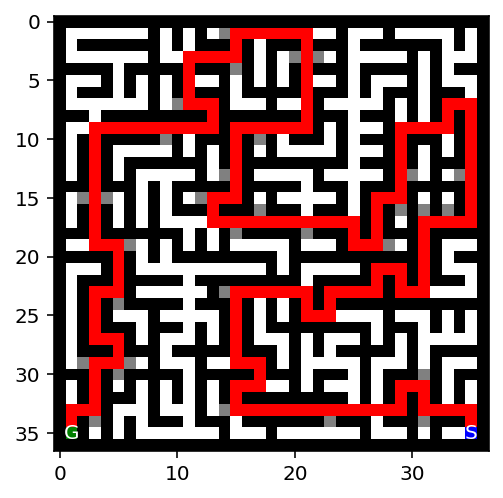

algorithm : DFS
path_cost : 210
nodes_expanded : 459
max_tree_depth : 210
max_tree_size : 489
max_frontier_size : 33


In [121]:
from collections import deque   # used as stack or queue for frontier
from operator import add, sub   # used for elementwise tuple addition in conjunction with map()
from random import randint      # used for random choice of DFS exploration direction

directions = {
    "N" : (0, 1),
    "E" : (1, 0),
    "S" : (0, -1),
    "W" : (-1, 0)
}

def depth_first_search(maze, release = True, randomize = True, depth_limit = -1):
    # Determine initial and goal states
    initial = find_pos(maze)
    G = where(maze == 'G')
    goals = {(G[0][i], G[1][i]) for i in range(len(G[0]))}

    # Initialize data structures
    reached = set()
    frontier = deque()
    dlist = list(directions.keys())
    backtrack = False
    depth = 0
    metrics = {
        "path": [],
        "algorithm": "DFS",
        "path_cost": 0,
        "nodes_expanded": 0,
        "max_tree_depth": 0,
        "max_tree_size": 0,
        "max_frontier_size": 0
    }

    # Populate data structures
    current = Node(initial, None, None, 0)
    reached.add(current)
    frontier.append(current)

    # Loop while nodes exist in the frontier
    while len(frontier):
        # If the previous iteration did not add any nodes to the stack,
        # then the algorithm is backtracking and the set of reached
        # nodes can be purged.
        if backtrack and release:
            branch = frontier.pop()
            while(current != branch.parent):
                reached.remove(current)
                current = current.parent
            frontier.append(branch)

        # Assume at the start of each iteration
        # that the algorithm is backtracking
        backtrack = True

        # Pop node from frontier stack
        current = frontier.pop()
        metrics["nodes_expanded"] += 1

        # Algorithm is complete if goal is expanded to
        if current.pos in goals:
            break

        # If depth limit is specified and current node is at limit,
        # skip current node instead of expanding from it
        if depth_limit > -1 and current.cost == depth_limit:
            continue

        # Check adjacent nodes in a random order
        if randomize:
            rand = randint(-4, -1)
        else:
            rand = -4
        for i in range(rand, rand + 4):
            modifier = directions[dlist[i]]
            border = Node(tuple(map(add, current.pos, modifier)), current, dlist[i], current.cost + 1)
            # Add adjacent node if it has not been visited and is not a wall
            if border not in reached and look(maze, border.pos) != 'X':
                frontier.append(border)
                reached.add(border)
                # Inform the next iteration that the algorithm is not backtracking
                backtrack = False
                # Update metrics
                if border.cost > metrics["max_tree_depth"]:
                    metrics["max_tree_depth"] = border.cost
                metrics["max_tree_size"] += 1

        # Update max frontier size
        if len(frontier) > metrics["max_frontier_size"]:
            metrics["max_frontier_size"] = len(frontier)

    # If loop exits without breaking, return None
    else:
        return None

    # Generate path
    metrics["path"] = current.get_path_from_root()
    metrics["path_cost"] = len(metrics["path"]) - 1

    # Update maze with reached and path nodes
    for r in reached:
        maze[r.pos[0], r.pos[1]] = '.'
    for p in metrics["path"]:
        maze[p.pos[0], p.pos[1]] = 'P'
    maze[initial[0], initial[1]] = 'S'
    for g in goals:
        maze[g[0], g[1]] = 'G'

    # Return metrics
    return metrics

# Test algorithm
%run maze_helper.py
with open("large_maze.txt", "r") as file:
    maze_str = file.read()
maze = parse_maze(maze_str)
%time metrics = depth_first_search(maze)
show_maze(maze)
for key, value in metrics.items():
    if key != "path":
        print(key, ":", value)

How does BFS and DFS deal with loops (cycles)?

These implementations use a `reached` data structure which records what nodes have already been visited. The functions do not add previously visited nodes to the frontier.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

Both implementations are complete, because they are guaranteed to continue until a solution is found. However, only the breadth-first search is optimal, because it searches all nodes of the same cost before exploring higher cost nodes for the goal. Depth-first search returns the first solution it finds, which may not have the lowest cost.

The time complexity of both solutions is linear with regards to the size of the maze because they traverse without repetition. The worst-case space complexity is also linear relative to the size of the maze because the recorded path may traverse the entire maze. However, the depth first search implementation will utilize much less memory on average, because it *only* stores the current path.

## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

Wall time: 22.5 ms


<Figure size 432x288 with 0 Axes>

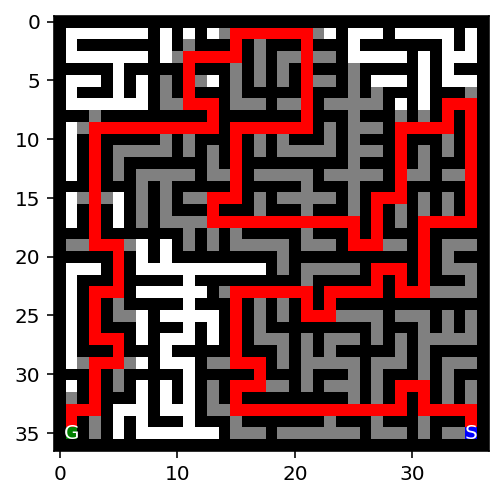

algorithm : GBS
path_cost : 210
nodes_expanded : 467
max_tree_depth : 210
max_tree_size : 486
max_frontier_size : 21


In [122]:
from operator import add, sub   # used for elementwise tuple addition in conjunction with map()
from queue import PriorityQueue # used for frontier

directions = {
    "N" : (0, 1),
    "E" : (1, 0),
    "S" : (0, -1),
    "W" : (-1, 0)
}

def manhattan_distance(pos1, pos2):
    distance = 0
    difference = map(sub, pos1, pos2)
    difference = map(abs, difference)
    for dimension in difference:
        distance += dimension
    return distance

def greedy_best_first_search(maze):
    # Determine the inital and goal states
    initial = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")

    # Initialize data structures
    reached = set()
    frontier = PriorityQueue()
    depth = 0
    metrics = {
        "path": [],
        "algorithm": "GBS",
        "path_cost": 0,
        "nodes_expanded": 0,
        "max_tree_depth": 0,
        "max_tree_size": 0,
        "max_frontier_size": 0
    }

    # Populate data structures
    current = Node(initial, None, None, 0)
    reached.add(current)
    frontier.put((manhattan_distance(initial, goal), current))

    # Loop while there are nodes in the frontier
    while not frontier.empty():
        # Pull node from frontier queue
        current = frontier.get()
        metrics["nodes_expanded"] += 1

        # If this node is the goal, return the path
        if current[1].pos == goal:
            break

        # Check adjacent nodes in each direction
        for direction, modifier in directions.items():
            border = Node(tuple(map(add, current[1].pos, modifier)), current[1], direction, current[1].cost + 1)
            # Do not add adjacent node if it is a wall
            if border not in reached and look(maze, border.pos) != 'X':
                reached.add(border)
                # Sort frontier by h(n)
                frontier.put((manhattan_distance(border.pos, goal), border))
                # Update metrics
                if border.cost > metrics["max_tree_depth"]:
                    metrics["max_tree_depth"] = border.cost
                metrics["max_tree_size"] += 1

        # Update max frontier size
        if frontier.qsize() > metrics["max_frontier_size"]:
            metrics["max_frontier_size"] = frontier.qsize()

    # Generate path
    metrics["path"] = current[1].get_path_from_root()
    metrics["path_cost"] = len(metrics["path"]) - 1

    # Update maze with reached and path nodes
    for r in reached:
        maze[r.pos[0], r.pos[1]] = '.'
    for p in metrics["path"]:
        maze[p.pos[0], p.pos[1]] = 'P'
    maze[initial[0], initial[1]] = 'S'
    maze[goal[0], goal[1]] = 'G'

    # Return metrics
    return metrics

# Test algorithm
%run maze_helper.py
with open("large_maze.txt", "r") as file:
    maze_str = file.read()
    maze = parse_maze(maze_str)
%time metrics = greedy_best_first_search(maze)
show_maze(maze)
for key, value in metrics.items():
    if key != "path":
        print(key, ":", value)

Wall time: 23.5 ms


<Figure size 432x288 with 0 Axes>

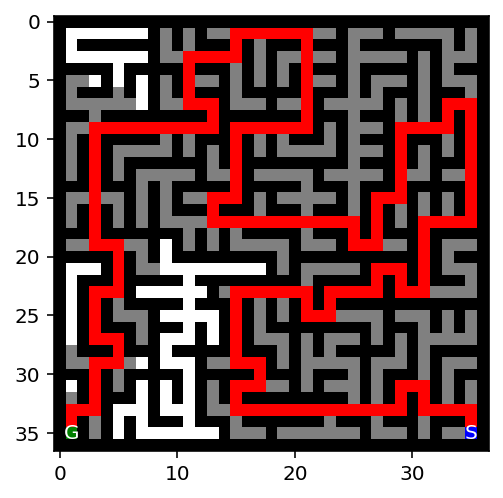

algorithm : A*
path_cost : 210
nodes_expanded : 550
max_tree_depth : 210
max_tree_size : 556
max_frontier_size : 12


In [123]:
from operator import add, sub   # used for elementwise tuple addition in conjunction with map()
from queue import PriorityQueue # used for frontier

directions = {
    "N" : (0, 1),
    "E" : (1, 0),
    "S" : (0, -1),
    "W" : (-1, 0)
}

def manhattan_distance(pos1, pos2):
    distance = 0
    difference = map(sub, pos1, pos2)
    difference = map(abs, difference)
    for dimension in difference:
        distance += dimension
    return distance

def A_star(maze):
    reached = set()
    # Determine inital and goal states
    initial = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")

    # Initialize necessary data structures
    reached = set()
    frontier = PriorityQueue()
    depth = 0
    metrics = {
        "path": [],
        "algorithm": "A*",
        "path_cost": 0,
        "nodes_expanded": 0,
        "max_tree_depth": 0,
        "max_tree_size": 0,
        "max_frontier_size": 0
    }

    # Populate data structures
    current = Node(initial, None, None, 0)
    reached.add(current)
    frontier.put((manhattan_distance(initial, goal), current))

    # Loop while there are nodes in the frontier
    while not frontier.empty():
        # Pull node from frontier queue
        current = frontier.get()
        metrics["nodes_expanded"] += 1

        # If this node is the goal, return the path
        if current[1].pos == goal:
            break

        # Check adjacent nodes in each direction
        for direction, modifier in directions.items():
            border = Node(tuple(map(add, current[1].pos, modifier)), current[1], direction, current[1].cost + 1)
            # Do not add adjacent node if it is a wall
            if border not in reached and look(maze, border.pos) != 'X':
                reached.add(border)
                # Sort frontier by g(n) + h(n)
                frontier.put((manhattan_distance(border.pos, goal) + border.cost, border))
                # Update metrics
                if border.cost > metrics["max_tree_depth"]:
                    metrics["max_tree_depth"] = border.cost
                metrics["max_tree_size"] += 1

        # Update max frontier size
        if frontier.qsize() > metrics["max_frontier_size"]:
            metrics["max_frontier_size"] = frontier.qsize()

    # Generate path
    metrics["path"] = current[1].get_path_from_root()
    metrics["path_cost"] = len(metrics["path"]) - 1

    # Update maze with reached and path nodes
    for r in reached:
        maze[r.pos[0], r.pos[1]] = '.'
    for p in metrics["path"]:
        maze[p.pos[0], p.pos[1]] = 'P'
    maze[initial[0], initial[1]] = 'S'
    maze[goal[0], goal[1]] = 'G'

    # Return metrics
    return metrics

# Test algorithm
%run maze_helper.py
with open("large_maze.txt", "r") as file:
    maze_str = file.read()
    maze = parse_maze(maze_str)
%time metrics = A_star(maze)
show_maze(maze)
for key, value in metrics.items():
    if key != "path":
        print(key, ":", value)

Are your implementations complete and optimal? What is the time and space complexity?

Both implementations are complete as they are guaranteed to continue searching the maze until a path from the start to the goal is found. However, neither implementation is optimal because the imperfect heuristic could cause either algorithm to travel to a location that increases path cost, despite having a lower heuristic.

Worst case time and space complexity is linear in relation to the size of the maze for both implementations.

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts. 

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [142]:
results = {
    "empty": [],
    "empty_2": [],
    "open": [],
    "wall": [],
    "loops": [],
    "small": [],
    "medium": [],
    "large": []
}

for type, metric in results.items():
    with open(type + "_maze.txt", "r") as file:
        maze_str = file.read()
    maze = parse_maze(maze_str)
    results[type].append(breadth_first_search(maze.copy()))
    results[type].append(depth_first_search(maze.copy()))
    results[type].append(greedy_best_first_search(maze.copy()))
    results[type].append(A_star(maze.copy()))
    print(type)

empty
empty_2
open
wall
loops
small
medium
large


It should be noted that on mazes with relatively open spaces, DFS may take a very long time to complete. The reason for this is that when the algorithm releases nodes from the `reached` data structure when backtracking occurs, it allows the nodes to be traversed again when exploring from another branch. This can cause the algorithm to explore the same node many times, but as part of different paths. One way to prevent this from occurring is to disable node releasing and permanently recording explored nodes. However, this nullifies the algorithm's space complexity advantage.

In [151]:
from pandas import DataFrame
from pandas import set_option

set_option('display.max_columns', 6)
set_option('display.width', 600)
columns = ['algorithm', 'path_cost', 'nodes_expanded', 'max_tree_depth', 'max_tree_size', 'max_frontier_size']

for type, metrics in results.items():
    table = DataFrame(columns = columns)
    for row in metrics:
        table = table.append(row, ignore_index=True)
    table = table.drop(["path"], axis = 1)
    print(type.capitalize(), "maze")
    print(table.to_string(index = False))
    print()

Empty maze
algorithm path_cost nodes_expanded max_tree_depth max_tree_size max_frontier_size
      BFS        14             96             15            97                12
      DFS        32             55             34            87                34
      GBS        14             15             14            42                29
       A*        14             64             14            93                31

Empty_2 maze
algorithm path_cost nodes_expanded max_tree_depth max_tree_size max_frontier_size
      BFS        14             96             15            97                12
      DFS        18             19             18            36                19
      GBS        14             15             14            42                29
       A*        14             64             14            93                31

Open maze
algorithm path_cost nodes_expanded max_tree_depth max_tree_size max_frontier_size
      BFS        54            683             54           68

array([[<AxesSubplot:title={'center':'path_cost'}>,
        <AxesSubplot:title={'center':'nodes_expanded'}>,
        <AxesSubplot:title={'center':'max_tree_depth'}>,
        <AxesSubplot:title={'center':'max_tree_size'}>,
        <AxesSubplot:title={'center':'max_frontier_size'}>]], dtype=object)

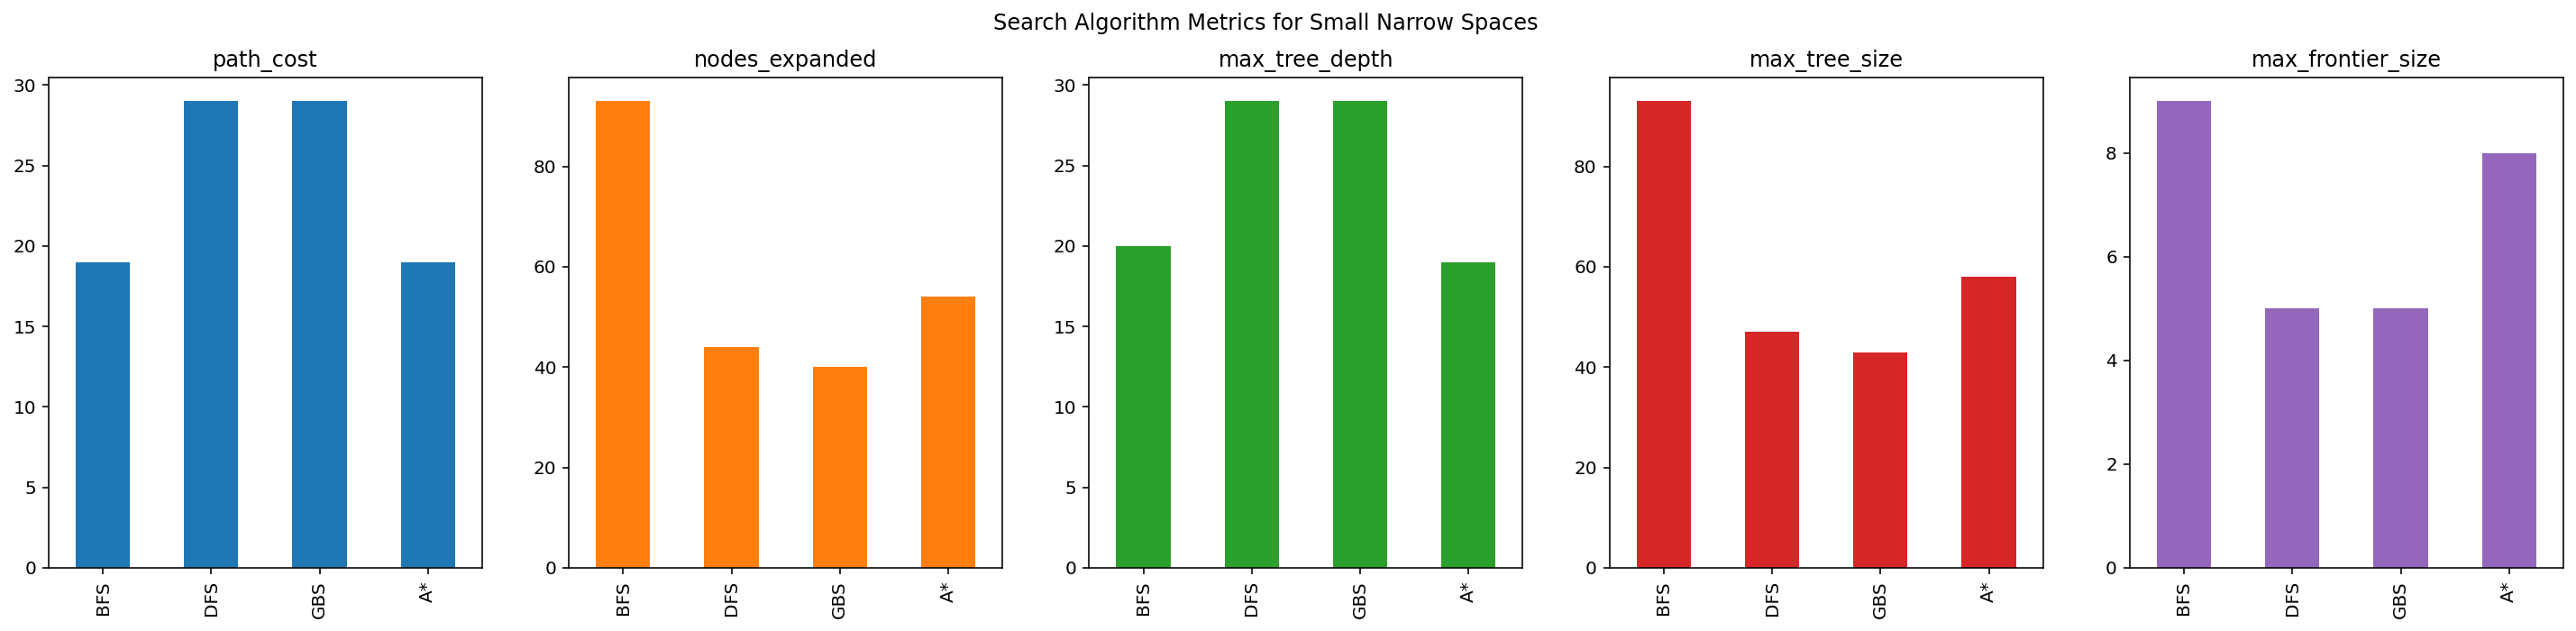

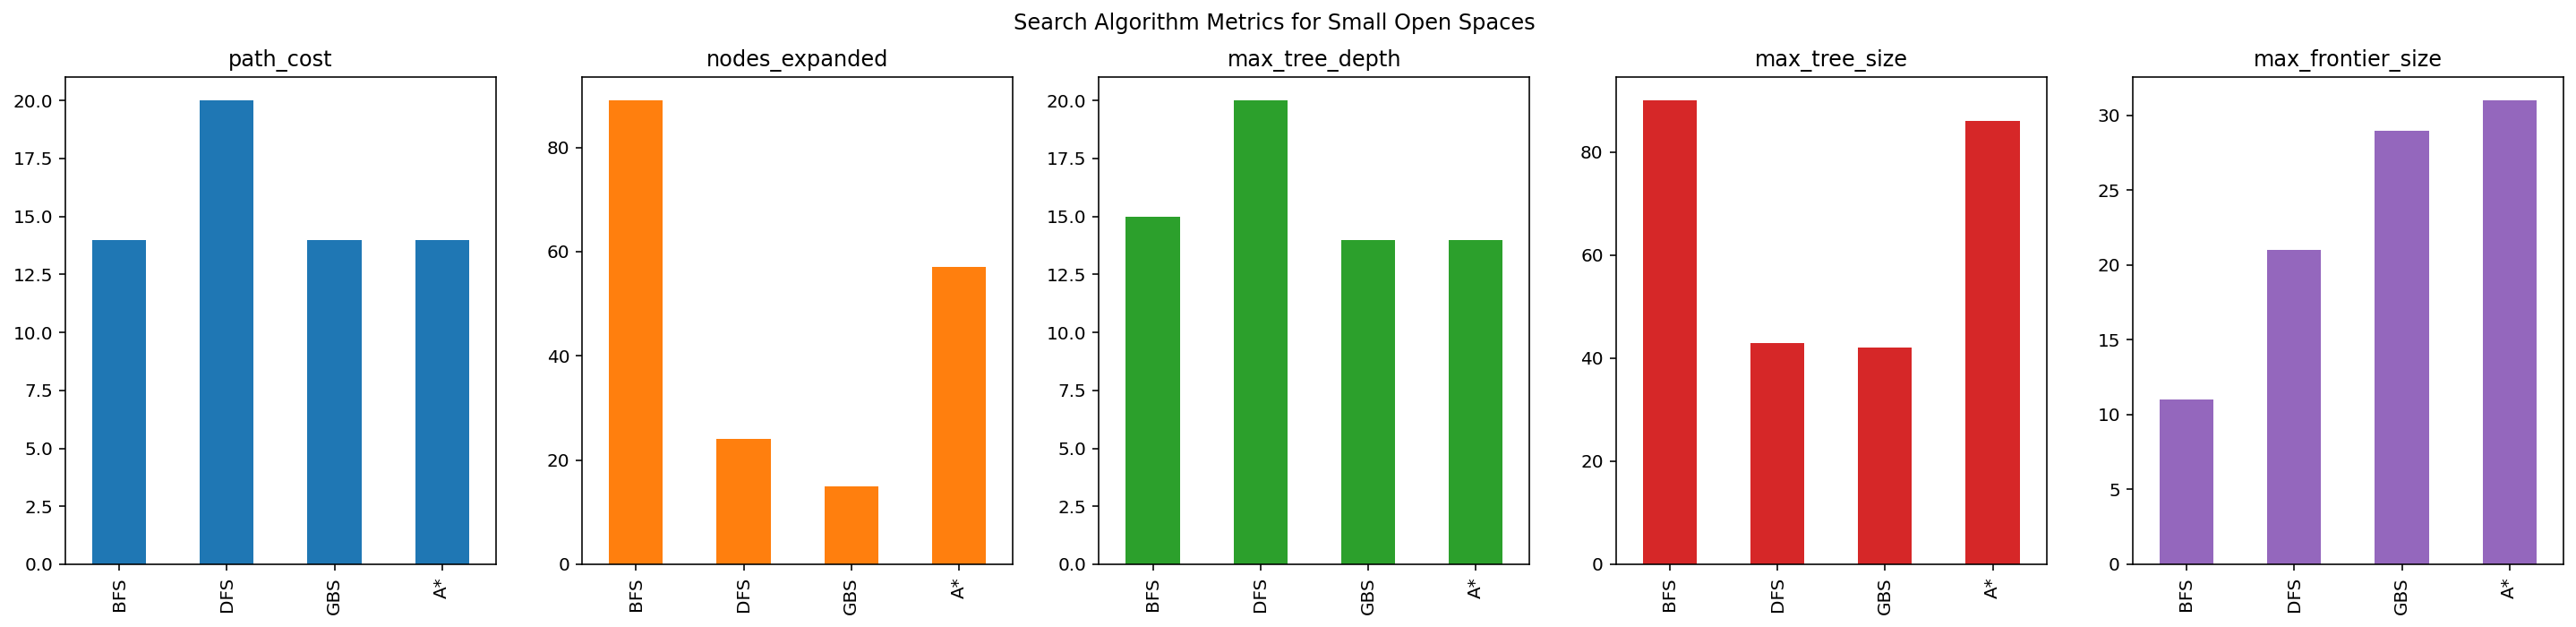

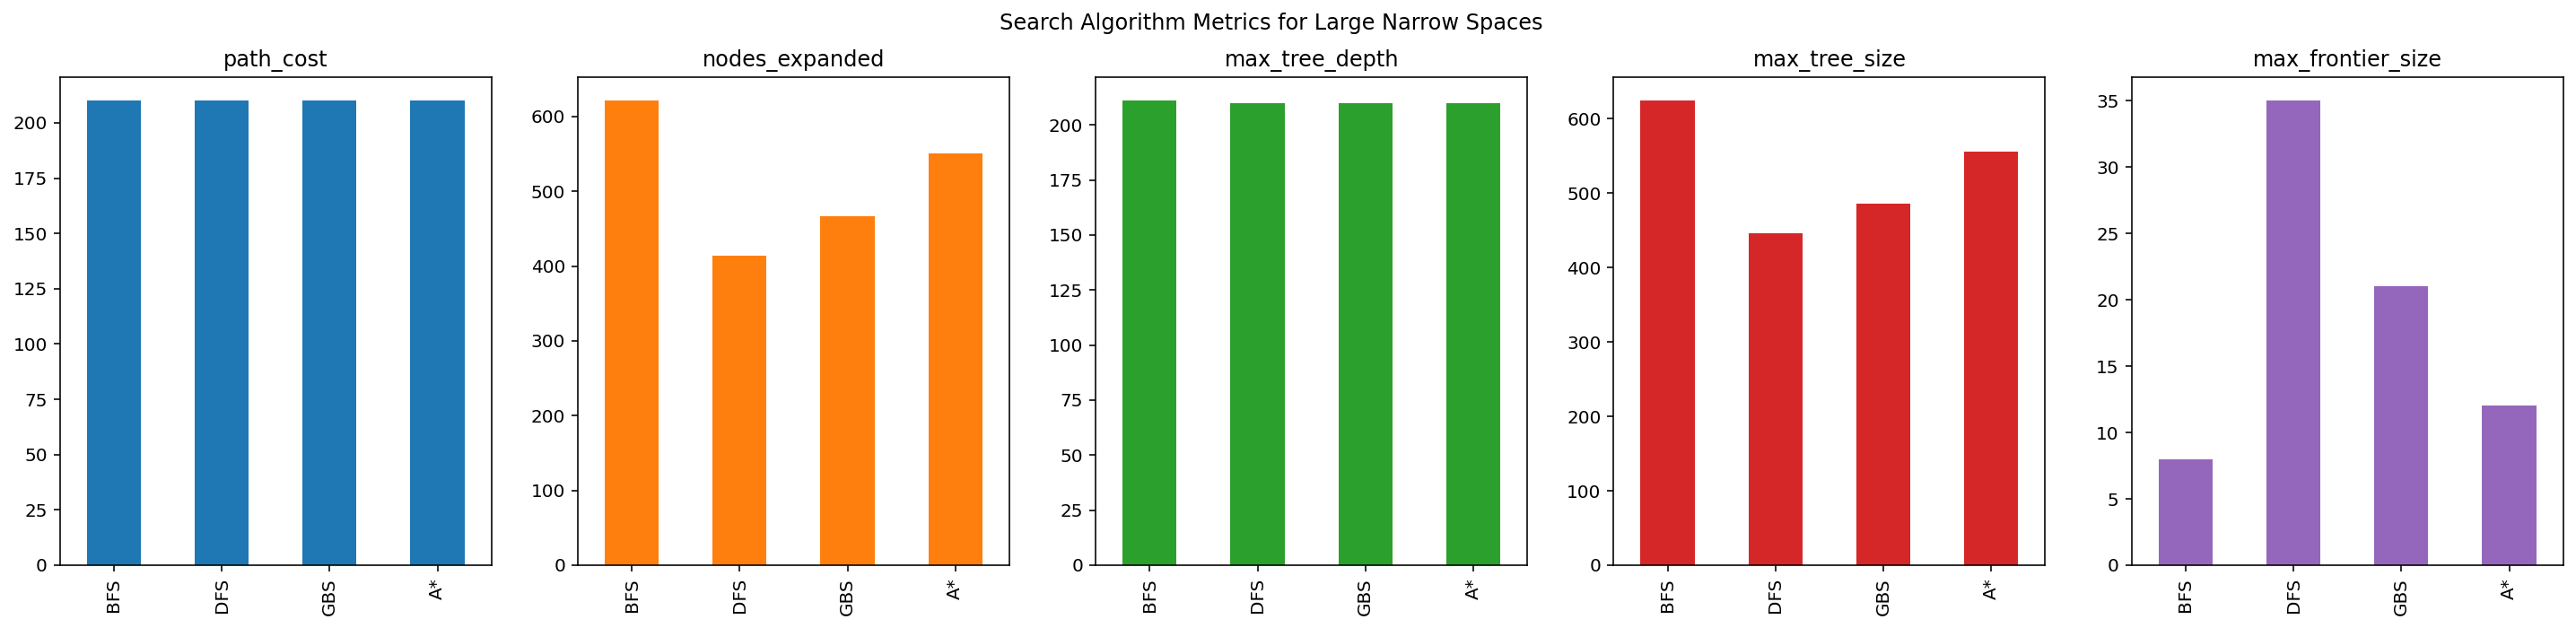

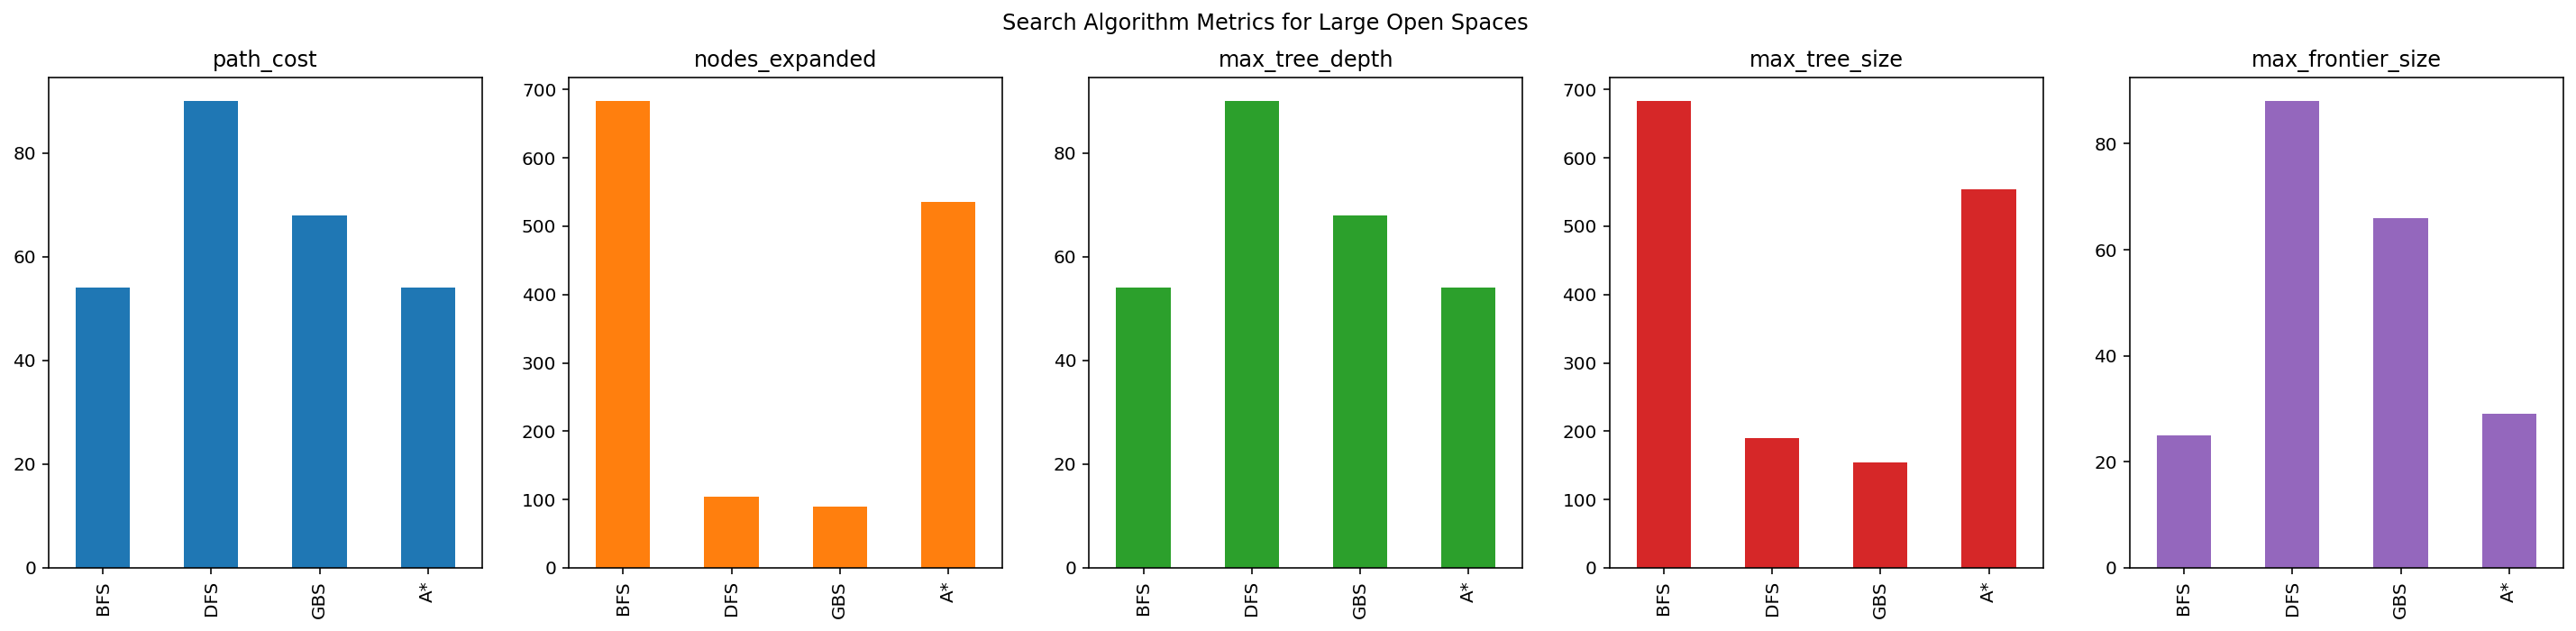

In [180]:
from matplotlib import pyplot

small_maze_table = DataFrame(columns = columns)
for row in results["small"]:
    small_maze_table = small_maze_table.append(row, ignore_index=True)
small_maze_table = small_maze_table.drop(["path"], axis = 1)
small_maze_table.plot(
    title = "Search Algorithm Metrics for Small Narrow Spaces",
    x = "algorithm",
    subplots = True,
    xlabel = "",
    layout = (1,5),
    kind = "bar",
    figsize = (25, 5),
    legend = False
)

wall_maze_table = DataFrame(columns = columns)
for row in results["wall"]:
    wall_maze_table = wall_maze_table.append(row, ignore_index=True)
wall_maze_table = wall_maze_table.drop(["path"], axis = 1)
wall_maze_table.plot(
    title = "Search Algorithm Metrics for Small Open Spaces",
    x = "algorithm",
    subplots = True,
    xlabel = "",
    layout = (1,5),
    kind = "bar",
    figsize = (25, 5),
    legend = False
)

large_maze_table = DataFrame(columns = columns)
for row in results["large"]:
    large_maze_table = large_maze_table.append(row, ignore_index=True)
large_maze_table = large_maze_table.drop(["path"], axis = 1)
large_maze_table.plot(
    title = "Search Algorithm Metrics for Large Narrow Spaces",
    x = "algorithm",
    subplots = True,
    xlabel = "",
    layout = (1,5),
    kind = "bar",
    figsize = (25, 5),
    legend = False
)

open_maze_table = DataFrame(columns = columns)
for row in results["open"]:
    open_maze_table = open_maze_table.append(row, ignore_index=True)
open_maze_table = open_maze_table.drop(["path"], axis = 1)
open_maze_table.plot(
    title = "Search Algorithm Metrics for Large Open Spaces",
    x = "algorithm",
    subplots = True,
    xlabel = "",
    layout = (1,5),
    kind = "bar",
    figsize = (25, 5),
    legend = False
)

Discuss the most important lessons you have learned from implementing the different search strategies.

Every single search strategy has its own tradeoffs. BFS is optimal, but it often requires mapping a large portion of the state space to a search tree. DFS is not optimal, but it can be designed to store much fewer nodes in its search tree at any given point. Informed searches can arrive at a solution much faster than an uninformed search, but that depends on the accuracy of the heuristic. Sometimes, there is no good heuristic that can be used. The choices made all depend on the computing resources available to the agent. An AI designer must seek to optimize search strategies as much as they seek to opmitize solutions.

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

Wall time: 1.22 s


<Figure size 432x288 with 0 Axes>

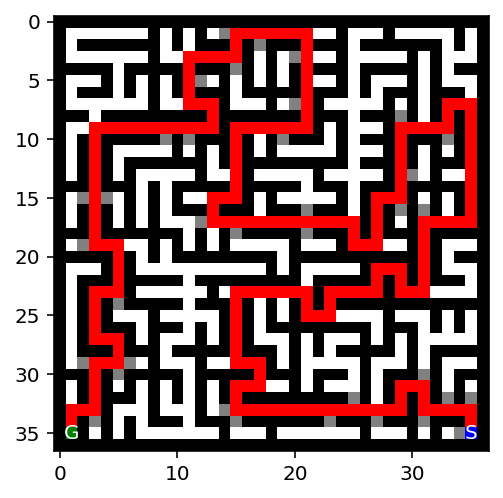

algorithm : IDS
path_cost : 210
nodes_expanded : 435
max_tree_depth : 210
max_tree_size : 470
max_frontier_size : 38


In [125]:
def iterative_deepening_search(maze):
    for depth in range(maze.shape[0] * maze.shape[1]):
        result = depth_first_search(maze, depth_limit = depth)
        if result is not None:
            result["algorithm"] = "IDS"
            return result

# Test algorithm
%run maze_helper.py
with open("large_maze.txt", "r") as file:
    maze_str = file.read()
    maze = parse_maze(maze_str)
%time metrics = iterative_deepening_search(maze)
show_maze(maze)
for key, value in metrics.items():
    if key != "path":
        print(key, ":", value)

In [183]:
from random import randrange
from numpy import where

def add_goal(maze):
    # Generate random x and y coordinate of a space in the maze
    x = 0
    y = 0
    while maze[x, y] != ' ':
        x = randrange(maze.shape[0])
        y = randrange(maze.shape[1])

    # Place a goal at the randomized coordinates
    maze[x, y] = 'G'

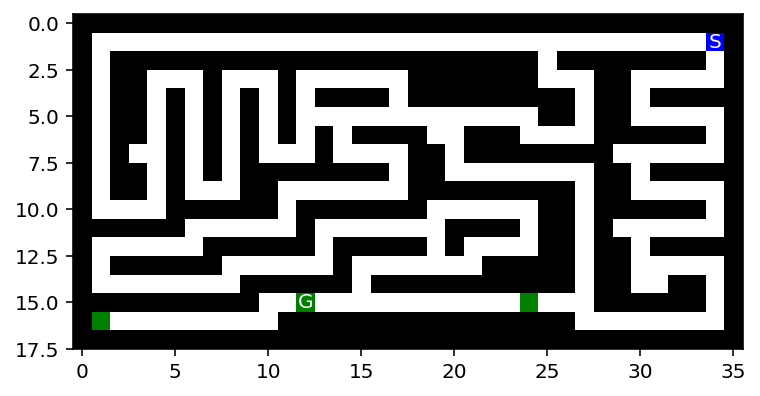


Medium maze with multiple goals
algorithm path_cost nodes_expanded max_tree_depth max_tree_size max_frontier_size
      BFS        44            170             44           172                 9
      DFS        50             57             50            58                 3
      IDS        44            210             44           211                 7



In [192]:
from pandas import DataFrame
from pandas import set_option

set_option('display.max_columns', 6)
set_option('display.width', 600)
columns = ['algorithm', 'path_cost', 'nodes_expanded', 'max_tree_depth', 'max_tree_size', 'max_frontier_size']

with open("medium_maze.txt", "r") as file:
    maze_str = file.read()
maze = parse_maze(maze_str)
add_goal(maze)
add_goal(maze)
show_maze(maze)

multigoal_results = []
multigoal_results.append(breadth_first_search(maze.copy()))
multigoal_results.append(depth_first_search(maze.copy()))
multigoal_results.append(iterative_deepening_search(maze.copy()))

multigoal_maze_table = DataFrame(columns = columns)
for row in multigoal_results:
    multigoal_maze_table = multigoal_maze_table.append(row, ignore_index=True)
multigoal_maze_table = multigoal_maze_table.drop(["path"], axis = 1)
print("\nMedium maze with multiple goals")
print(multigoal_maze_table.to_string(index = False))
print()

array([[<AxesSubplot:title={'center':'path_cost'}>,
        <AxesSubplot:title={'center':'nodes_expanded'}>,
        <AxesSubplot:title={'center':'max_tree_depth'}>,
        <AxesSubplot:title={'center':'max_tree_size'}>,
        <AxesSubplot:title={'center':'max_frontier_size'}>]], dtype=object)

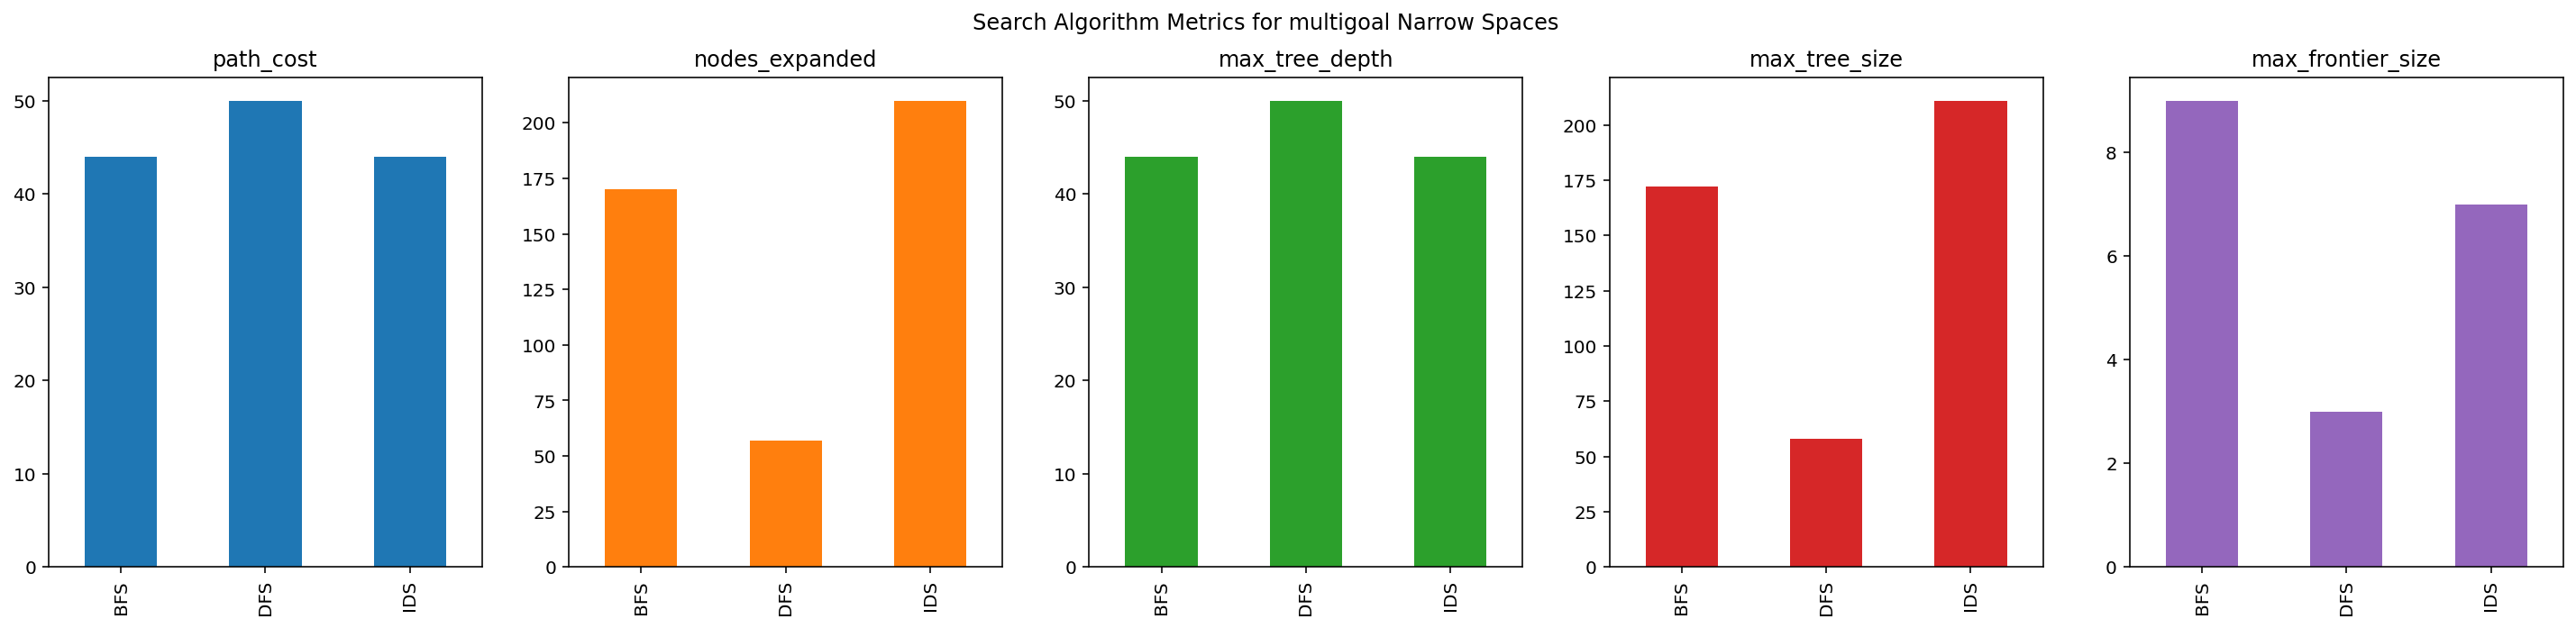

In [193]:
from matplotlib import pyplot

multigoal_maze_table.plot(
    title = "Search Algorithm Metrics for multigoal Narrow Spaces",
    x = "algorithm",
    subplots = True,
    xlabel = "",
    layout = (1,5),
    kind = "bar",
    figsize = (25, 5),
    legend = False
)

## More advanced tasks to think about

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [14]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [15]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [16]:
# Your code/answer goes here